In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import load_model

# Cargar modelo guardado
model = load_model("/content/drive/MyDrive/techespere/mlp_sigmiod_per_class.h5")

# Verifica que cargó bien
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1152)           │       885,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,502 (3.40 MB)

 Trainable params: 890,500 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/techespere/dataset.csv", sep=";")
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

X = df["text"].values
y = df["group"].values

In [4]:
import torch
from transformers import BertTokenizer, BertModel

# 1. Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model_embed = BertModel.from_pretrained("bert-base-uncased")

# 2. Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_embed = model_embed.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
def get_mean_embedding(text):
    # Tokenización y envío a GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        # SOLO token embeddings, sin positional encoding
        token_embeddings = model_embed.embeddings.word_embeddings(inputs["input_ids"])
        token_matrix = token_embeddings.squeeze(0)       # (n_tokens, d_model)
        mean_embedding = token_matrix.mean(dim=0)        # (d_model,)
    return mean_embedding.cpu().numpy()

In [6]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Y: np.array de strings como 'neurological|hepatorenal'
# Define el orden fijo de las clases (columnas):
CLASSES = ['cardiovascular', 'neurological', 'hepatorenal', 'oncological']

# Parseo simple: split por '|'
y_lists = [s.split('|') if isinstance(s, str) and s else [] for s in y]

mlb = MultiLabelBinarizer(classes=CLASSES)
y_bin = mlb.fit_transform(y_lists)  # shape: (n_samples, 4)

# Opcional: verificar orden
print("Orden de columnas:", mlb.classes_)  # ['cardiovascular','neurological','hepatorenal','oncological']

Orden de columnas: ['cardiovascular' 'neurological' 'hepatorenal' 'oncological']


In [7]:
X = np.vstack([get_mean_embedding(text) for text in df["text"].values])
print("Shape de X:", X.shape)  # (num_samples, d_model=768)

Shape de X: (3565, 768)


In [8]:
X.shape, y_bin.shape

((3565, 768), (3565, 4))

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder

# Paso 1: convertir de one-hot a etiquetas enteras
y_labels = np.argmax(y_bin, axis=1)

# Paso 2: aplicar submuestreo
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal_labels = rus.fit_resample(X, y_labels)

# Paso 3: volver a one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_bal = encoder.fit_transform(y_bal_labels.reshape(-1, 1))

print("Shape de X original:", X.shape)
print("Shape de X balanceado:", X_bal.shape)
print("Distribución original:", np.bincount(y_labels))
print("Distribución balanceada:", np.bincount(y_bal_labels))

Shape de X original: (3565, 768)
Shape de X balanceado: (948, 768)
Distribución original: [1268 1429  631  237]
Distribución balanceada: [237 237 237 237]


In [10]:
from sklearn.model_selection import train_test_split

# División en 60% train y 40% test
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.4,        # 40% para test
    random_state=42,      # semilla reproducible
    stratify=y_bal            # asegura misma proporción de clases en train y test
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


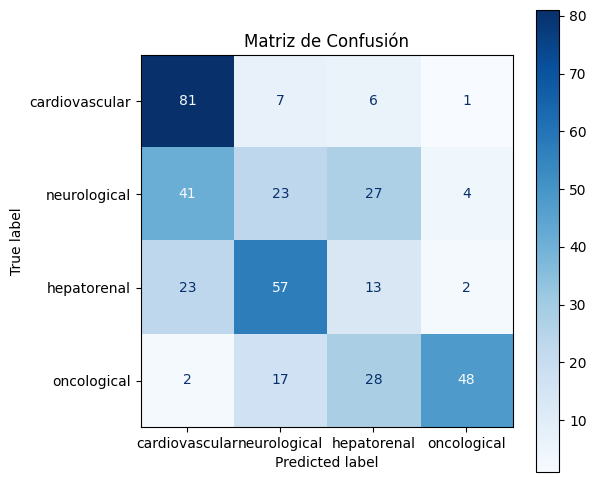

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predecir con el modelo
probs = model.predict(X_test)  # [n_samples, n_labels]
y_pred = (probs > 0.5).astype(int)

# 2. Convertir probabilidades a clases (elegir la clase con mayor probabilidad)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # porque y_test está en one-hot

# 3. Construir matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 4. Mostrar matriz de confusión con nombres de clases
labels = ["cardiovascular", "neurological", "hepatorenal", "oncological"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# 5. Plot
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [49]:
# Fine tunning del modelo

# Congelar todas las capas
for layer in model.layers:
    layer.trainable = False

# Solo entrenar la última capa densa
model.layers[-1].trainable = True

In [50]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

In [51]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5
)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - auc: 0.7197 - loss: 1.1440 - precision: 0.3691 - recall: 0.6369 - val_auc: 0.7664 - val_loss: 1.0715 - val_precision: 0.4035 - val_recall: 0.6763
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7393 - loss: 1.1174 - precision: 0.3755 - recall: 0.6353 - val_auc: 0.7762 - val_loss: 1.0533 - val_precision: 0.4117 - val_recall: 0.6868
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7703 - loss: 1.0538 - precision: 0.3984 - recall: 0.6862 - val_auc: 0.7831 - val_loss: 1.0371 - val_precision: 0.4201 - val_recall: 0.6921
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7594 - loss: 1.0776 - precision: 0.3915 - recall: 0.6419 - val_auc: 0.7913 - val_loss: 1.0215 - val_precision: 0.4286 - val_recall: 0.7026
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7802 - loss: 1.0399 - precision: 0.4223 - recall: 0.6962 - val_auc: 0.7994 - val_loss: 1.0057 - val_precision: 0.4401 - val_recall: 0.7158


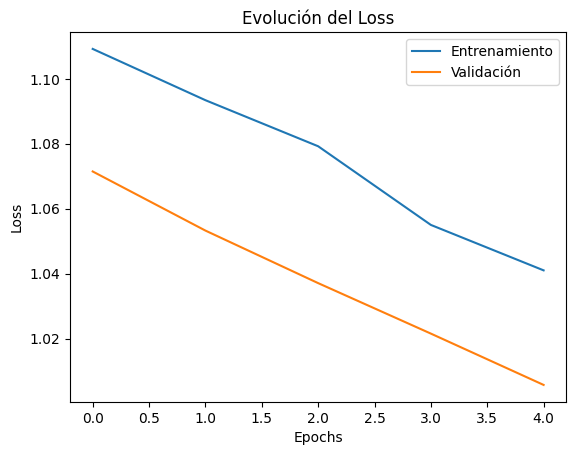

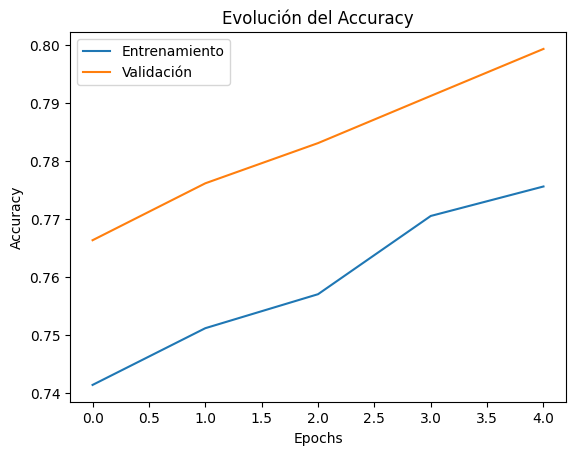

In [52]:
import matplotlib.pyplot as plt

# Suponiendo que entrenaste con:
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# ===========================
# 1. Plot del Loss
# ===========================
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Evolución del Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ===========================
# 2. Plot del Accuracy
# ===========================
plt.plot(history.history["auc"], label="Entrenamiento")
plt.plot(history.history["val_auc"], label="Validación")
plt.title("Evolución del Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [53]:
import numpy as np
from sklearn.metrics import f1_score

# 1. Predecir sobre el conjunto de prueba
y_pred_prob = model.predict(X_test)

# 2. Pasar de probabilidades a clases
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. Calcular F1-score
f1_macro = f1_score(y_true, y_pred, average="macro")   # Promedio por clase
f1_micro = f1_score(y_true, y_pred, average="micro")   # Promedio global
f1_weighted = f1_score(y_true, y_pred, average="weighted") # Balanceado por soporte

print("F1-macro:", f1_macro)
print("F1-micro:", f1_micro)
print("F1-weighted:", f1_weighted)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
F1-macro: 0.4890913965618371
F1-micro: 0.5131578947368421
F1-weighted: 0.4890913965618371


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_multilabel_model(input_dim, n_labels):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(int(1.5*input_dim), activation="relu")(inputs)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_labels, activation="sigmoid")(x)  # sigmoid por salida
    return models.Model(inputs, outputs)

model_2 = build_multilabel_model(input_dim=768, n_labels=4)  # ejemplo: 100 features, 4 etiquetas
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1152)           │       885,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,502 (3.40 MB)

 Trainable params: 890,500 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [13]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

In [14]:
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - auc: 0.4912 - loss: 1.3959 - precision: 0.2406 - recall: 0.4421 - val_auc: 0.5634 - val_loss: 1.3837 - val_precision: 0.2527 - val_recall: 0.7500
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5371 - loss: 1.3834 - precision: 0.2656 - recall: 0.6228 - val_auc: 0.6308 - val_loss: 1.3696 - val_precision: 0.3271 - val_recall: 0.7842
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5975 - loss: 1.3695 - precision: 0.2849 - recall: 0.7450 - val_auc: 0.6491 - val_loss: 1.3619 - val_precision: 0.3213 - val_recall: 0.7974
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6396 - loss: 1.3565 - precision: 0.2947 - recall: 0.7567 - val_auc: 0.6528 - val_loss: 1.3508 - val_precision: 0.2852 - val_recall: 0.7947
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.6497 - loss: 1.3440 - precision: 0.3110 - recall: 0.7655 - val_auc: 0.6411 - val_loss: 1.3407 - val_precision: 0.3088 - val_recall: 0.6632
Epoch 6/

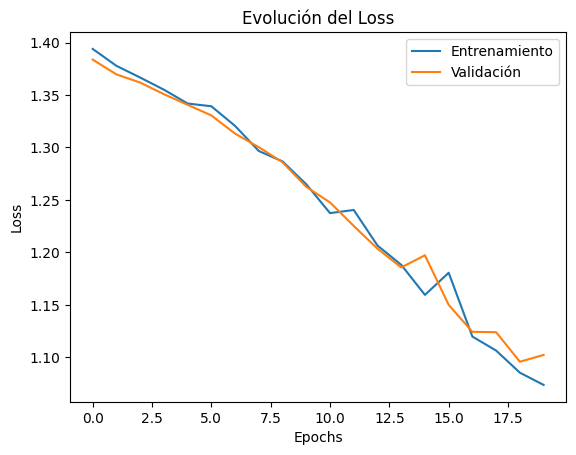

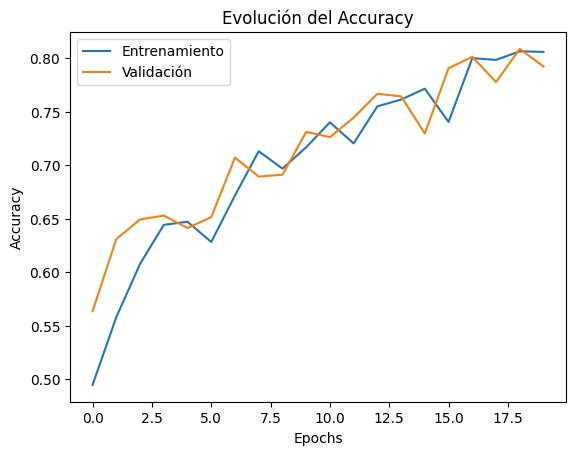

In [15]:
import matplotlib.pyplot as plt

# Suponiendo que entrenaste con:
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# ===========================
# 1. Plot del Loss
# ===========================
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Evolución del Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ===========================
# 2. Plot del Accuracy
# ===========================
plt.plot(history.history["auc"], label="Entrenamiento")
plt.plot(history.history["val_auc"], label="Validación")
plt.title("Evolución del Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import f1_score

# 1. Predecir sobre el conjunto de prueba
y_pred_prob = model_2.predict(X_test)

# 2. Pasar de probabilidades a clases
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. Calcular F1-score
f1_macro = f1_score(y_true, y_pred, average="macro")   # Promedio por clase
f1_micro = f1_score(y_true, y_pred, average="micro")   # Promedio global
f1_weighted = f1_score(y_true, y_pred, average="weighted") # Balanceado por soporte

print("F1-macro:", f1_macro)
print("F1-micro:", f1_micro)
print("F1-weighted:", f1_weighted)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
F1-macro: 0.5914021971635479
F1-micro: 0.5868421052631579
F1-weighted: 0.5914021971635479
